# Unit 2: Fisheries Collapse Module Overview

This module will focus on examining a crucial global issue and important scientific debate about the state of global fisheries.  In this module we will seek to reproduce some of the most widely cited examples of species collapse ever, and examine the evidence behind an influential and widely cited paper on global fisheries, [Worm et al 2006](http://doi.org/10.1126/science.1132294).  However, rather than use the limited data available to Boris Worm and colleagues in 2006, we will be drawing from the best and most recent stock asssement data available today to see how those patterns have faired.  

In this module we will also begin to master one of the most important concepts in data science: manipulation of tabular data using relational database concepts. Instead of working with independent data.frames, we will be working with a large relational database which contains many different tables of different sizes and shapes, but that all all related to each other through a series of different ids.  



## The Database

We will use data from the RAM Legacy Stock Assessment Database.  In order to better introduce some important emerging technologies, we will be accessing these data directly from a relatively new platform that is now playing a key role in data sharing in machine learning communities, with the memorable name, HuggingFace.  We will be streaming data from <https://huggingface.co/datasets/cboettig/ram_fisheries/tree/main/v4.65>.  We will have more to say about this approach as we progress.



## Researcher Spotlight: Daniel Pauly

Science is done by real people.  There are many influential and colorful characters in the global fisheries debate.  I want to highlight Professor Pauly not just because he is so famous, but as an early believer in Open Science and Data Science, before we had either of those words.  His contributions in making fisheries data more open were ground breaking for their time.  I'm also indebted to Professor Pauly whom I had the privilege to meet when I was a junior scientist who had only recently released one of my first software packages, aimed at making data from FishBase more accessible. Academic researchers are typically defined by scientific publications, not software, so I was shocked that Pauly already knew of my software package, and that he encouraged me to continue developing software.  Even today that is not common advice, but I believed him, and it's probably a good reason I am where I am today.  Scientific textbooks and courses are often critiqued for failing to recognize the contributions of those from minority backgrounds, but as the texts are written on global change ecology, I think none will omit the works for Professor Pauly.




## Science Introduction

Background abbreviated documentary, features many of the leading authors on both sides https://vimeo.com/44104959

In [1]:
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so


# Exercise 1: Investigating the North-Atlantic Cod

Now we are ready to dive into our data. First, We seek to replicate the following figure from the Millennium Ecosystem Assessment Project using the RAM data.

![](https://espm-157.github.io/website-r/img/cod.jpg)


In [2]:
con = ibis.duckdb.connect()

base = "https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/"

tsmetrics = con.read_csv(base + "tsmetrics.csv")
timeseries = con.read_csv(base + "timeseries.csv")
stock = con.read_csv(base + "stock.csv")
assessment = con.read_csv(base + "assessment.csv")
area = con.read_csv(base + "area.csv")

In [3]:
tsmetrics.filter(_.tsunique == "CdivMSY-ratio").head().execute()

,tscategory,tsshort,tslong,tsunitsshort,tsunitslong,tsunique
0,CATCH or LANDINGS,CdivMSY,Catch divided by MSY,ratio,ratio,CdivMSY-ratio


In [4]:
timeseries.filter(_.stockid == "COD1ABCDE").select(_.tsid).distinct().execute()

,tsid
0,CdivMEANC-ratio
1,TC-MT
2,TL-MT
3,TCbest-MT


In [5]:
fish = (timeseries
    .drop(_.stocklong)
    .rename(tsunique = "tsid")
    .join(tsmetrics, "tsunique")
    .join(stock, "stockid")
    .join(assessment, "assessid")
)

new_fish = (
    fish.rename(country = 'primary_country')
    .join(area, 'country')
)

cod_catch = (new_fish
    .filter(_.tscategory == "CATCH or LANDINGS")
    .filter(_.tsunique == "TCbest-MT")
    .filter(_.commonname == 'Atlantic cod')
    )

In [6]:
cod_catch.filter(_.tsyear == 2000, _.stockid == "COD5Zjm").select(_.assessid, _.tsvalue, _.tsyear, _.areaid).execute()

,assessid,tsvalue,tsyear,areaid
0,TRAC-COD5Zjm-1977-2017-SISIMP2021,2429,2000,multinational-TRAC-5Zjm
1,TRAC-COD5Zjm-1978-2010-WATSON,1640,2000,multinational-TRAC-5Zjm
2,TRAC-COD5Zjm-1978-2018-SISIMP2021-2,788,2000,multinational-TRAC-5Zjm
3,TRAC-COD5Zjm-1978-2019-SISIMP2021-2,788,2000,multinational-TRAC-5Zjm
4,TRAC-COD5Zjm-1978-2020-SISIMP2021-2,788,2000,multinational-TRAC-5Zjm
...,...,...,...,...
1444,TRAC-COD5Zjm-1978-2018-SISIMP2021-2,788,2000,multinational-TRAC-5Zjm
1445,TRAC-COD5Zjm-1978-2019-SISIMP2021-2,788,2000,multinational-TRAC-5Zjm
1446,TRAC-COD5Zjm-1978-2020-SISIMP2021-2,788,2000,multinational-TRAC-5Zjm
1447,TRAC-COD5Zjm-1978-2015-SISIMP2016,2430,2000,multinational-TRAC-5Zjm


In [7]:
null_values_table = cod_catch.mutate(tsvalue=ibis.case()
                                    .when(cod_catch.tsvalue == 'NA', ibis.null())
                                    .else_(cod_catch.tsvalue)
                                    .end())





In [8]:
null_values_table = null_values_table.mutate(tsvalue=_.tsvalue.cast("double"))

In [9]:
cod_catch_agg = null_values_table.group_by(_.country, _.tsyear).aggregate(tsvalue=_.tsvalue.mean())
cod_catch_agg.execute()

,country,tsyear,tsvalue
0,USA,1976,NaN
1,USA,1983,31315.600000
2,USA,1986,18933.400000
3,USA,1991,28468.800000
4,USA,1994,11980.000000
...,...,...,...
209,Canada,1934,108248.063333
210,Canada,1939,84922.634667
211,Canada,1940,83820.763667
212,Canada,1942,79063.879000


In [12]:
cod_catch_agg.schema()

ibis.Schema {
  country  string
  tsyear   int64
  tsvalue  float64
}

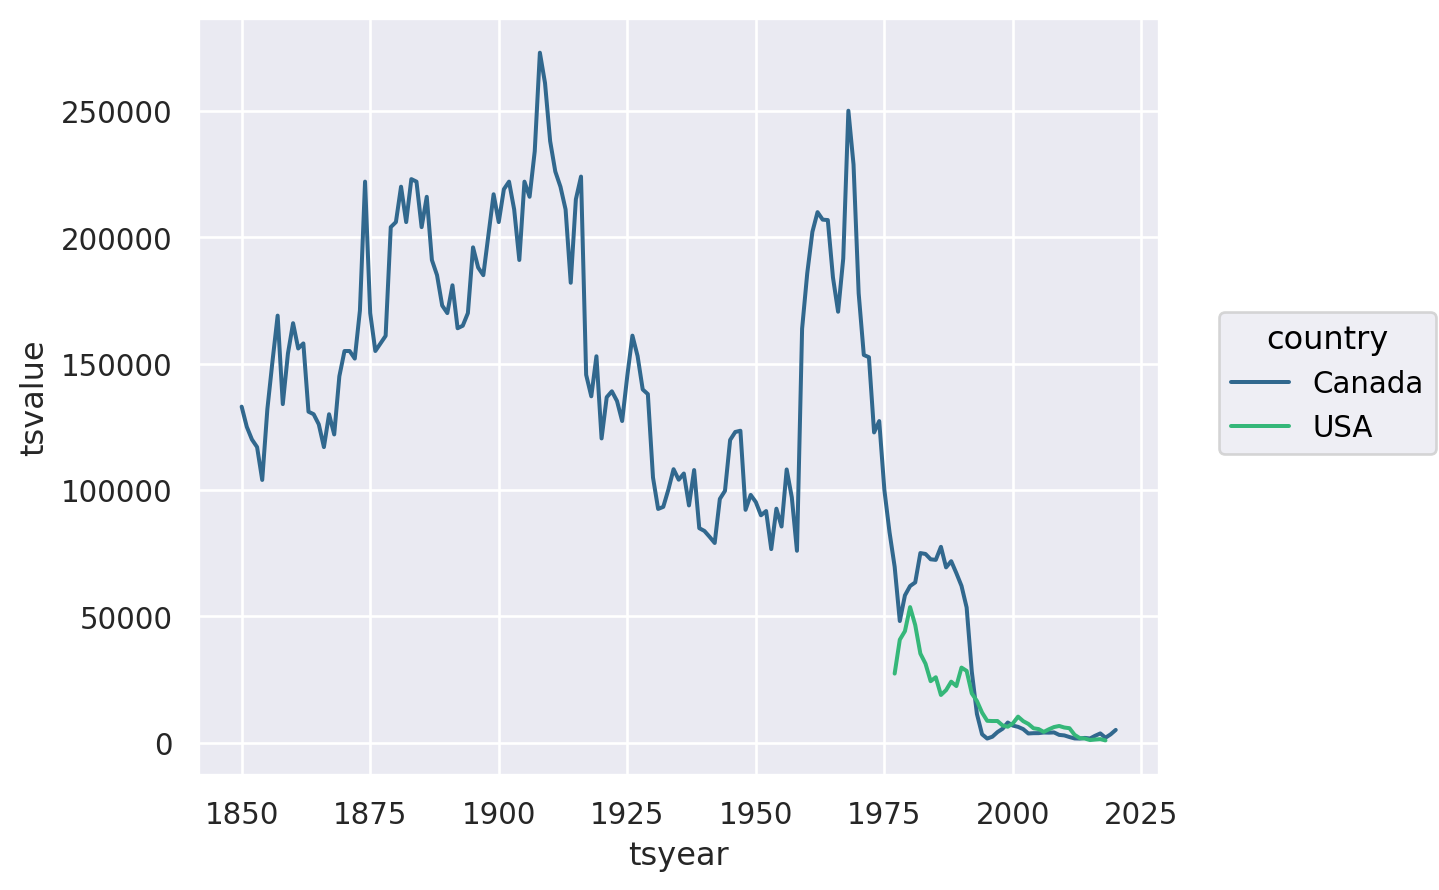

In [13]:
(
    so.Plot(cod_catch_agg, x="tsyear", y="tsvalue", color="country")
    .add(so.Line())
    .scale(color="viridis")
)

# Excersise 2: Global Fisheries 

## Stock Collapses

We seek to replicate the temporal trend in stock declines shown in [Worm et al 2006](http://doi.org/10.1126/science.1132294):

![](https://espm-157.github.io/website-r/img/worm2006.jpg)